In [2]:
# Since we will be generating a lot of charts, let's ensure that all matplotlib charts are rendered within the ipython shell

%matplotlib inline 

# Let's avoid printing of warnings
import warnings
warnings.filterwarnings('ignore')

# importing other libraries

import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
#from pandas_profiling import ProfileReport
from IPython.display import display


from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, cross_val_score, LeaveOneOut, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score

In [4]:
train=pd.read_csv('../data/train.csv')
test=pd.read_csv('../data/test.csv')
sample=pd.read_csv('../data/sample_submission.csv')

In [5]:
styles = [

    {'selector': 'table',
     'props': [('border', '1px solid black'),('border-left', '2px solid green')]},
    {'selector': 'th',
     'props': [('border-bottom', '1px solid black')]},
    {'selector': 'td',
     'props': [('border', '1px solid black')]},
]

In [6]:
display(train.head().style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.000000,0,0,Yes,Private,Urban,79.530000,31.100000,never smoked,0
1,1,Male,33.000000,0,0,Yes,Private,Rural,78.440000,23.900000,formerly smoked,0
2,2,Female,42.000000,0,0,Yes,Private,Rural,103.000000,40.300000,Unknown,0
3,3,Male,56.000000,0,0,Yes,Private,Urban,64.870000,28.800000,never smoked,0
4,4,Female,24.000000,0,0,No,Private,Rural,73.360000,28.800000,never smoked,0


In [7]:
display(test.head().style.set_table_styles(styles).background_gradient(cmap='BuPu'))

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.000000,0,0,Yes,Private,Rural,82.540000,33.400000,Unknown
1,15305,Male,70.000000,1,0,Yes,Private,Urban,72.060000,28.500000,Unknown
2,15306,Female,5.000000,0,0,No,children,Urban,103.720000,19.500000,Unknown
3,15307,Female,56.000000,0,0,Yes,Govt_job,Urban,69.240000,41.400000,smokes
4,15308,Male,32.000000,0,0,Yes,Private,Rural,111.150000,30.100000,smokes


In [8]:
display(sample.head().style.set_table_styles(styles).background_gradient(cmap='Purples'))

,id,stroke
0,15304,0.041296
1,15305,0.041296
2,15306,0.041296
3,15307,0.041296
4,15308,0.041296


In [9]:
if train.duplicated().sum()==0:
    print("\nThe training data has no duplicate rows")
else:
    print("\n There are " + str(train.duplicated().sum()) + " rows that are duplicate in the training set")
    


The training data has no duplicate rows


In [10]:
if test.duplicated().sum()==0:
    print("\nThe test data has no duplicate rows")
else:
    print("\n There are " + str(test.duplicated().sum()) + " rows that are duplicate in the test set")



The test data has no duplicate rows


In [11]:
display(train.describe().T.style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))

,count,mean,std,min,25%,50%,75%,max
id,15304.000000,7651.500000,4418.028595,0.000000,3825.750000,7651.500000,11477.250000,15303.000000
age,15304.000000,41.417708,21.444673,0.080000,26.000000,43.000000,57.000000,82.000000
hypertension,15304.000000,0.049726,0.217384,0.000000,0.000000,0.000000,0.000000,1.000000
heart_disease,15304.000000,0.023327,0.150946,0.000000,0.000000,0.000000,0.000000,1.000000
avg_glucose_level,15304.000000,89.039853,25.476102,55.220000,74.900000,85.120000,96.980000,267.600000
bmi,15304.000000,28.112721,6.722315,10.300000,23.500000,27.600000,32.000000,80.100000
stroke,15304.000000,0.041296,0.198981,0.000000,0.000000,0.000000,0.000000,1.000000


In [12]:
display(test.describe().T.style.set_table_styles(styles).background_gradient(cmap='BuPu'))

,count,mean,std,min,25%,50%,75%,max
id,10204.000000,20405.500000,2945.785407,15304.000000,17854.750000,20405.500000,22956.250000,25507.000000
age,10204.000000,41.920713,21.097956,0.080000,26.000000,43.500000,57.000000,82.000000
hypertension,10204.000000,0.051450,0.220925,0.000000,0.000000,0.000000,0.000000,1.000000
heart_disease,10204.000000,0.021756,0.145894,0.000000,0.000000,0.000000,0.000000,1.000000
avg_glucose_level,10204.000000,89.197766,25.914364,55.120000,75.060000,85.070000,96.750000,267.600000
bmi,10204.000000,28.242351,6.733863,11.500000,23.700000,27.700000,32.000000,97.600000


In [13]:
train['age_bins']= pd.qcut(train['age'], q=5, labels=['1. 0-20%ile', '2. 20-40%ile', '3. 40-60%ile', '4. 60-80%ile', '5. 80-100%ile'])
train['glucose_bins']= pd.qcut(train['avg_glucose_level'], q=5, labels=['1. 0-20%ile', '2. 20-40%ile', '3. 40-60%ile', '4. 60-80%ile', '5. 80-100%ile'])
train['bmi_bins']= pd.qcut(train['bmi'], q=5, labels=['1. 0-20%ile', '2. 20-40%ile', '3. 40-60%ile', '4. 60-80%ile', '5. 80-100%ile'])
train['bmi_bins_pop']=pd.cut(train['bmi'], bins=[0,18.5,25,30,85], labels=['under-weight', 'healthy', 'over-weight', 'obese'])
train['glucose_bins_pop']=pd.cut(train['avg_glucose_level'], bins=[0,99,125,300], labels=['normal', 'pre-diabetic', 'diabetic'])
train['age_bins_pop']=pd.cut(train['age'], bins=[0,2,16,30,60,100], labels=['babies', 'children', 'young adults', 'middle aged','senior'])

In [14]:
cont=['age','avg_glucose_level','bmi']
cat=['stroke','gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status','age_bins','glucose_bins','bmi_bins','age_bins_pop','glucose_bins_pop','bmi_bins_pop']

In [15]:
# We can also look at the distributions of continuous variables and check for skew
def skew_cat(skew_val):
    if skew_val>0.5:
        return 'skewed towards the tail'
    elif skew_val<-.5:
        return 'skewed towards the head'
    else:
        return 'fairly symmetric'

def skew_chart(data,var,forsk):
    print("\n\nDistribution of " + str(var) + "\n")
    sns.displot(data=data, x=var, fill=True, height=5, aspect=1.5)
    plt.show()
    print("\nThe skew of "+str(var)+" is "+str("{:.2f}".format(forsk.skew())) + " which indicates that it is " + skew_cat(forsk.skew()))
    print("\n__________________________________________________________________________________________\n")



Distribution of age



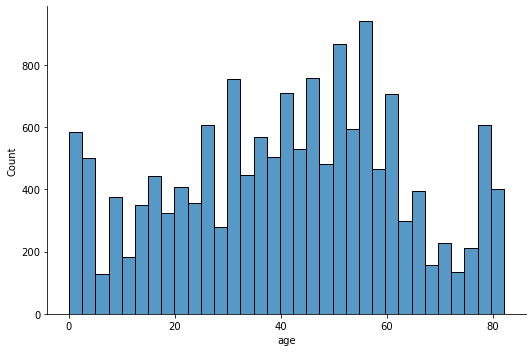


The skew of age is -0.10 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of avg_glucose_level



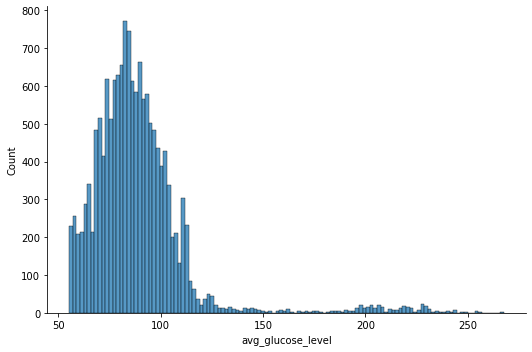


The skew of avg_glucose_level is 3.04 which indicates that it is skewed towards the tail

__________________________________________________________________________________________



Distribution of bmi



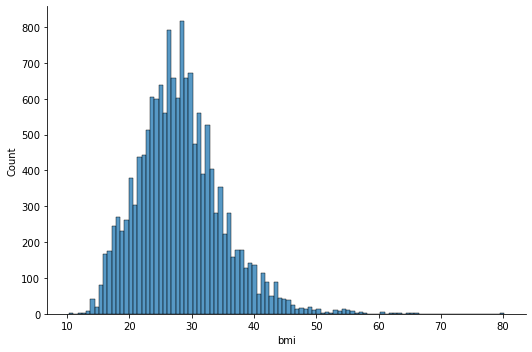


The skew of bmi is 0.71 which indicates that it is skewed towards the tail

__________________________________________________________________________________________



In [16]:
#[skew_chart(train,i,train[i]) for i in cont]
for i in cont:
    skew_chart(train,i,train[i])

In [17]:
def outlier(dat,x,val):
      print("\nBox Plot for " + str(val)+"\n")
      plt.figure(figsize=(12, 6))
      custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
      sns.set_theme(style="white", palette=("Spectral"), rc=custom_params)
      sns.boxplot(x)
      plt.show()
      print("As per the 'Median +/- 1.5 times IQR")
      med=x.median()
      upq=np.percentile(x,75)
      lwq=np.percentile(x,25)
      iqr=upq-lwq
      #print (med,upq,lwq,iqr)

      print("\nFor "+str(val)+" there are " + str(len(dat[x<(med-1.5*(iqr))])) + "(" +str("{:.2f}".format(len(dat[x<(med-1.5*(iqr))])/len(x)*100)) +"%)"
            + " outliers on the lower side(< " + str("{:.2f}".format(med-1.5*(iqr)))+")")
      print("\nAnd " + str(len(dat[x>(med+1.5*(iqr))])) + "(" +str("{:.2f}".format(len(dat[x>(med+1.5*(iqr))])/len(x)*100)) +"%)"
            + " outliers on the upper side(> "+str("{:.2f}".format(med+1.5*(iqr)))+")")
      print("\n__________________________________________________________________________________________")
      print("__________________________________________________________________________________________\n")


Box Plot for age



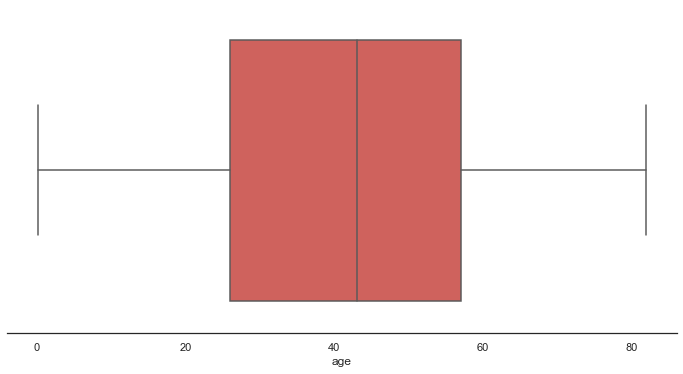

As per the 'Median +/- 1.5 times IQR

For age there are 0(0.00%) outliers on the lower side(< -3.50)

And 0(0.00%) outliers on the upper side(> 89.50)

__________________________________________________________________________________________
__________________________________________________________________________________________


Box Plot for avg_glucose_level



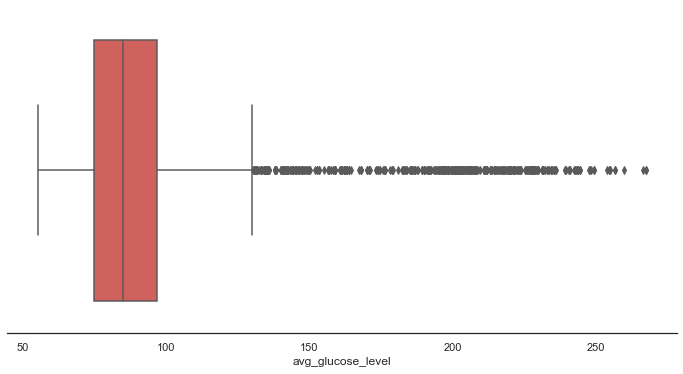

As per the 'Median +/- 1.5 times IQR

For avg_glucose_level there are 0(0.00%) outliers on the lower side(< 52.00)

And 765(5.00%) outliers on the upper side(> 118.24)

__________________________________________________________________________________________
__________________________________________________________________________________________


Box Plot for bmi



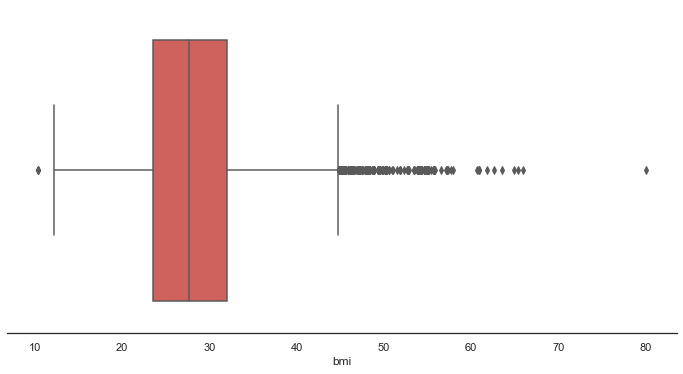

As per the 'Median +/- 1.5 times IQR

For bmi there are 68(0.44%) outliers on the lower side(< 14.85)

And 730(4.77%) outliers on the upper side(> 40.35)

__________________________________________________________________________________________
__________________________________________________________________________________________



In [18]:
#[outlier(train,train[i],i) for i in cont]
for i in cont:
    outlier(train,train[i],i)


Univariate of : stroke


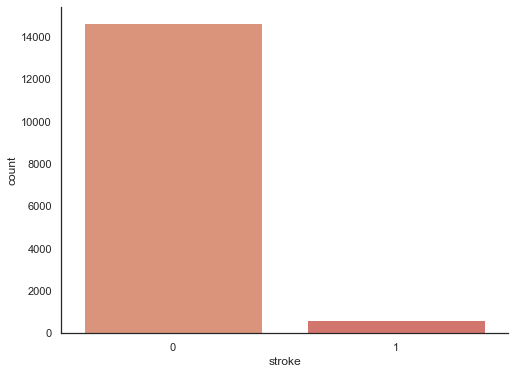


 Count distribution of : stroke


,stroke
0,14672
1,632



 %age distribution of : stroke


,stroke
0,95.870000
1,4.130000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : gender


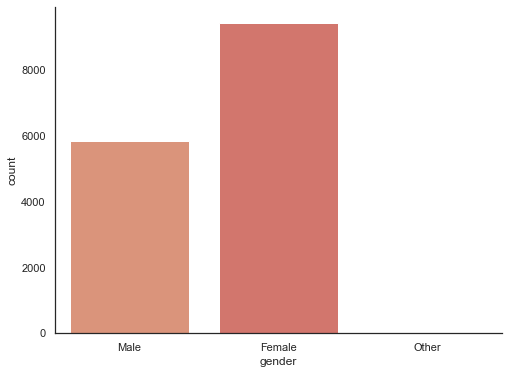


 Count distribution of : gender


,gender
Female,9446
Male,5857
Other,1



 %age distribution of : gender


,gender
Female,61.720000
Male,38.270000
Other,0.010000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : hypertension


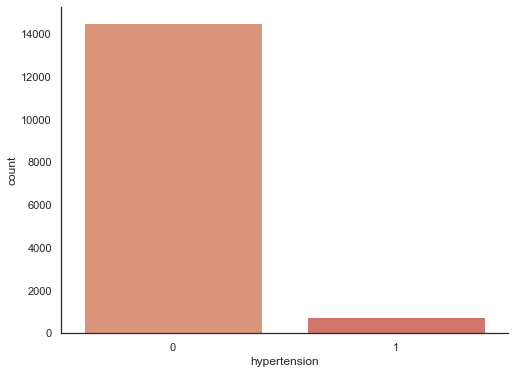


 Count distribution of : hypertension


,hypertension
0,14543
1,761



 %age distribution of : hypertension


,hypertension
0,95.030000
1,4.970000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : heart_disease


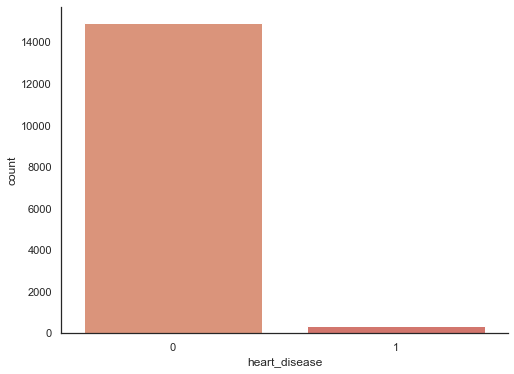


 Count distribution of : heart_disease


,heart_disease
0,14947
1,357



 %age distribution of : heart_disease


,heart_disease
0,97.670000
1,2.330000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : ever_married


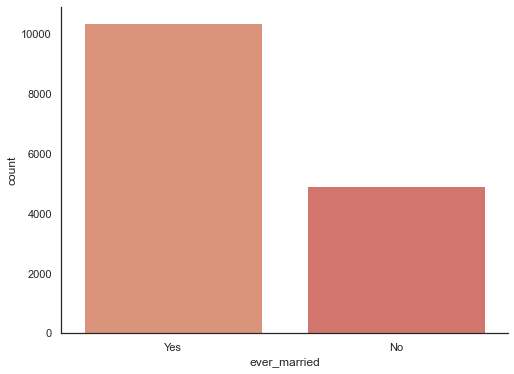


 Count distribution of : ever_married


,ever_married
Yes,10385
No,4919



 %age distribution of : ever_married


,ever_married
Yes,67.860000
No,32.140000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : work_type


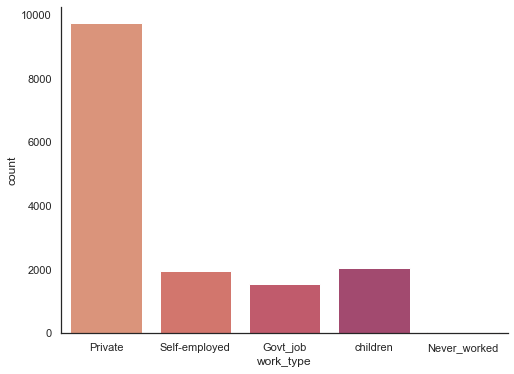


 Count distribution of : work_type


,work_type
Private,9752
children,2038
Self-employed,1939
Govt_job,1533
Never_worked,42



 %age distribution of : work_type


,work_type
Private,63.720000
children,13.320000
Self-employed,12.670000
Govt_job,10.020000
Never_worked,0.270000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : Residence_type


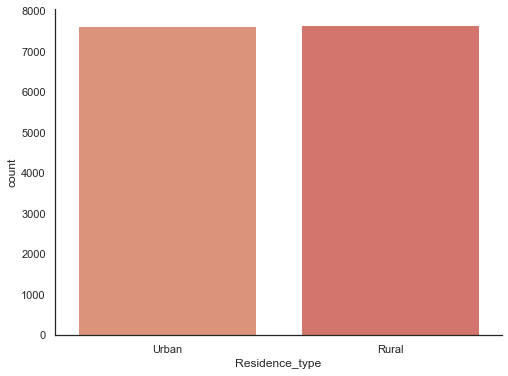


 Count distribution of : Residence_type


,Residence_type
Rural,7664
Urban,7640



 %age distribution of : Residence_type


,Residence_type
Rural,50.080000
Urban,49.920000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : smoking_status


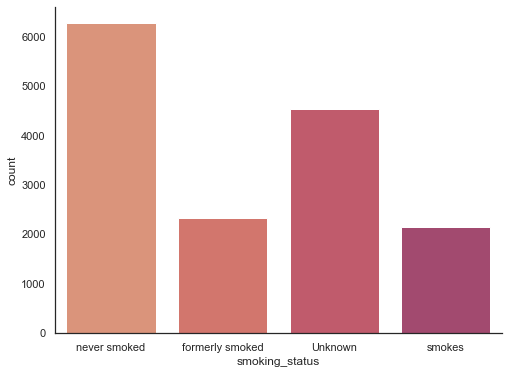


 Count distribution of : smoking_status


,smoking_status
never smoked,6281
Unknown,4543
formerly smoked,2337
smokes,2143



 %age distribution of : smoking_status


,smoking_status
never smoked,41.040000
Unknown,29.690000
formerly smoked,15.270000
smokes,14.000000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : age_bins


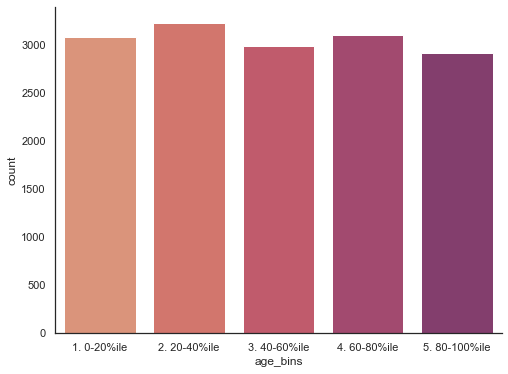


 Count distribution of : age_bins


,age_bins
2. 20-40%ile,3227
4. 60-80%ile,3101
1. 0-20%ile,3077
3. 40-60%ile,2988
5. 80-100%ile,2911



 %age distribution of : age_bins


,age_bins
2. 20-40%ile,21.090000
4. 60-80%ile,20.260000
1. 0-20%ile,20.110000
3. 40-60%ile,19.520000
5. 80-100%ile,19.020000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : glucose_bins


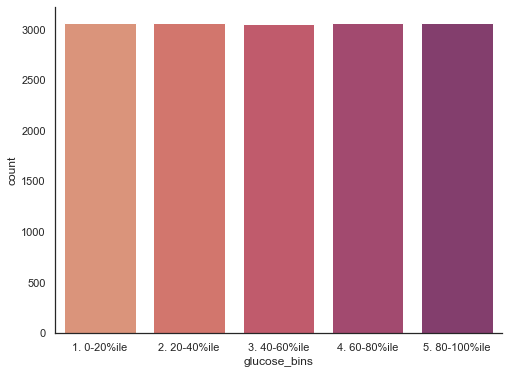


 Count distribution of : glucose_bins


,glucose_bins
2. 20-40%ile,3068
1. 0-20%ile,3063
4. 60-80%ile,3061
5. 80-100%ile,3061
3. 40-60%ile,3051



 %age distribution of : glucose_bins


,glucose_bins
2. 20-40%ile,20.050000
1. 0-20%ile,20.010000
4. 60-80%ile,20.000000
5. 80-100%ile,20.000000
3. 40-60%ile,19.940000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : bmi_bins


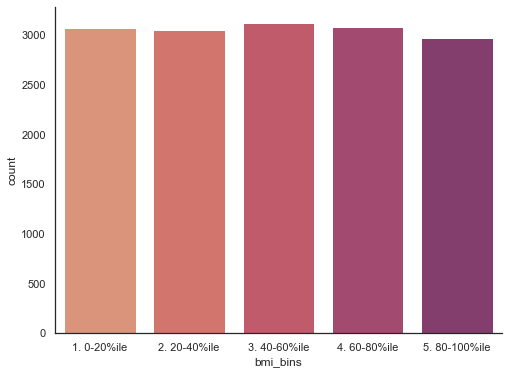


 Count distribution of : bmi_bins


,bmi_bins
3. 40-60%ile,3125
4. 60-80%ile,3083
1. 0-20%ile,3074
2. 20-40%ile,3049
5. 80-100%ile,2973



 %age distribution of : bmi_bins


,bmi_bins
3. 40-60%ile,20.420000
4. 60-80%ile,20.150000
1. 0-20%ile,20.090000
2. 20-40%ile,19.920000
5. 80-100%ile,19.430000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : age_bins_pop


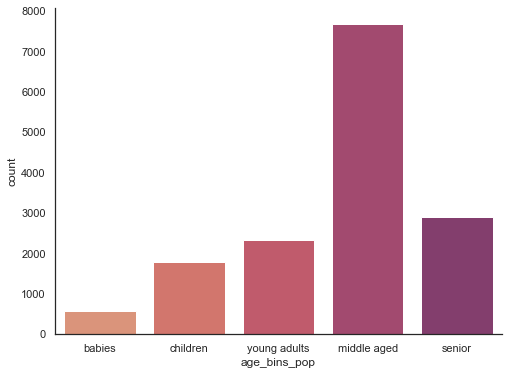


 Count distribution of : age_bins_pop


,age_bins_pop
middle aged,7688
senior,2911
young adults,2331
children,1789
babies,585



 %age distribution of : age_bins_pop


,age_bins_pop
middle aged,50.240000
senior,19.020000
young adults,15.230000
children,11.690000
babies,3.820000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : glucose_bins_pop


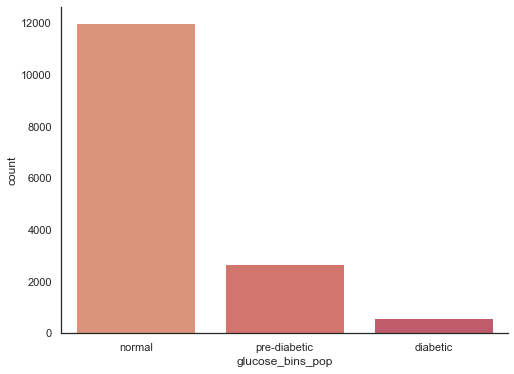


 Count distribution of : glucose_bins_pop


,glucose_bins_pop
normal,12029
pre-diabetic,2673
diabetic,602



 %age distribution of : glucose_bins_pop


,glucose_bins_pop
normal,78.600000
pre-diabetic,17.470000
diabetic,3.930000



_____________________________________________________________________
_____________________________________________________________________


Univariate of : bmi_bins_pop


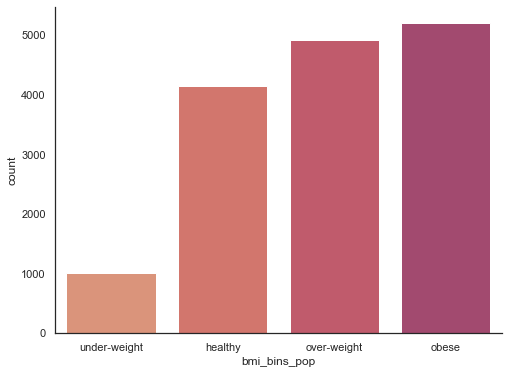


 Count distribution of : bmi_bins_pop


,bmi_bins_pop
obese,5213
over-weight,4928
healthy,4149
under-weight,1014



 %age distribution of : bmi_bins_pop


,bmi_bins_pop
obese,34.060000
over-weight,32.200000
healthy,27.110000
under-weight,6.630000



_____________________________________________________________________
_____________________________________________________________________



In [19]:
for i in cat:
    plt.figure(figsize=(8,6))
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="white", palette=("flare"), rc=custom_params)
    print("\nUnivariate of : " + i)
    sns.countplot(train[i])

    plt.show()
    print("\n Count distribution of : "+i)
    vc=train[i].value_counts()
    vc=pd.DataFrame(vc)
    display(vc.style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))

    print("\n %age distribution of : "+i)
    vc=train[i].value_counts(normalize=True, sort=True)*100
    vc=pd.DataFrame(vc.apply(lambda x:round(x,2)))
    display(vc.style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))
    print("\n_____________________________________________________________________")
    print("_____________________________________________________________________\n")


Relationship of age with the occurence of a stroke




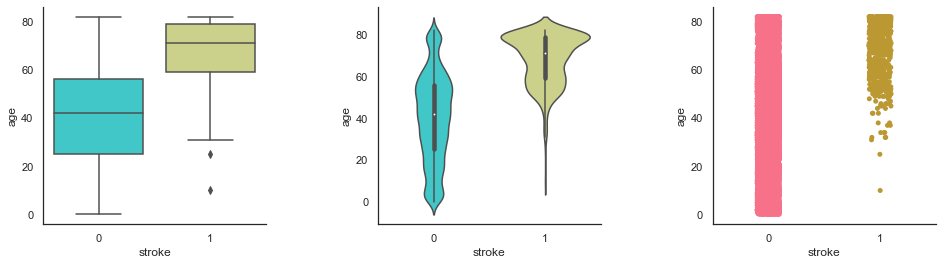


Student's t-test

t-value:  33.489287282255795
p-value:  2.3212839931652986e-237

There exists a significant relationship between stroke and age

__________________________________________________________________________________________
__________________________________________________________________________________________


Relationship of avg_glucose_level with the occurence of a stroke




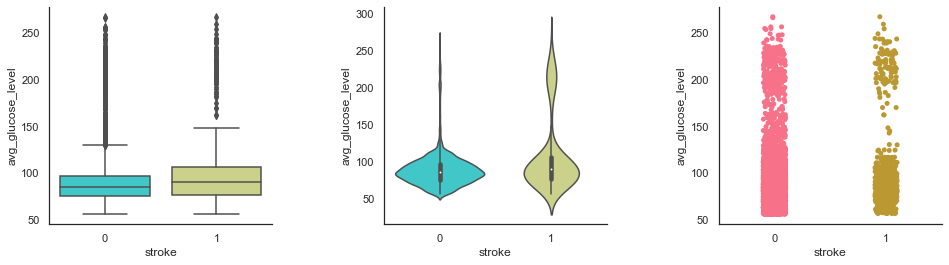


Student's t-test

t-value:  18.67454261968053
p-value:  5.711730284325392e-77

There exists a significant relationship between stroke and avg_glucose_level

__________________________________________________________________________________________
__________________________________________________________________________________________


Relationship of bmi with the occurence of a stroke




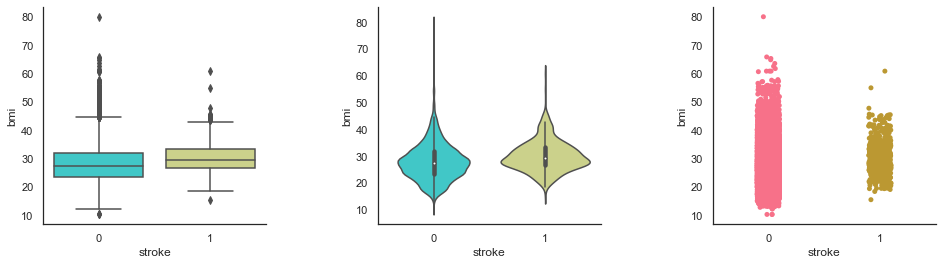


Student's t-test

t-value:  8.1065253056754
p-value:  5.600351429932325e-16

There exists a significant relationship between stroke and bmi

__________________________________________________________________________________________
__________________________________________________________________________________________



In [20]:
for i in cont:
    print("\nRelationship of " + i + " with the occurence of a stroke")
    print("\n")
    fig,axes= plt.subplots(1,3,figsize=(16,4))
    sns.set_context("notebook")
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(style="white", palette=("husl"), rc=custom_params)
    sns.boxplot(x='stroke',y=i,data=train,palette='rainbow',ax=axes[0])
    sns.violinplot(x="stroke", y=i, data=train,palette='rainbow',ax=axes[1])
    sns.stripplot(x="stroke", y=i, data=train,ax=axes[2])
    plt.subplots_adjust(wspace=.5, hspace=0.1)
    plt.show()
    print("\nStudent's t-test\n")
    # Define the responders and non-responders groups
    responders = train[train['stroke'] == 1][i]
    non_responders = train[train['stroke'] == 0][i]

    # Perform two-sample t-test
    t_val, p_val = stats.ttest_ind(responders, non_responders)

    # Print the results
    print("t-value: ", t_val)
    print("p-value: ", p_val)
    if p_val>.05:
        print("\nThere is no significant relationship between "+ 'stroke' +" and " + i)
    else:
        print("\nThere exists a significant relationship between "+ 'stroke' +" and " + i)

    print("\n__________________________________________________________________________________________")
    print("__________________________________________________________________________________________\n")


In [21]:
#define a function for categorical plot and a cross tabulation
def catp(x,y,dataset):
    print("\nExploring relationship between "+ y+ " and "+ x+"\n")
    
    #plt.figure(figsize=(8,8))
    sns.catplot(y=y, hue=x, kind="count", palette="Set2", edgecolor=".6",data=dataset);
    plt.show()
    
    print(x+" vs "+y+ "(Count)")
    crosstab=pd.crosstab(dataset[x],dataset[y])
    display(pd.DataFrame(crosstab).style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))
    print(x+" vs "+y+ "(%)")
    display(pd.DataFrame(crosstab.apply(lambda r:r/r.sum()*100,axis=0)).style.set_table_styles(styles).background_gradient(cmap='YlOrRd'))
    grp=0
    print('\nTests of proportions\n')
    for i in pd.unique(dataset[y]):
        success=np.array([dataset[dataset[x]==1].shape[0],crosstab[i][1]])
        samples=np.array([dataset.shape[0],crosstab[i].sum()])
        zstat,pvalue=proportions_ztest(count=success,nobs=samples,alternative='two-sided')
        print("\nFor "+str(y)+"="+str(i)+" the p-value of the proportion test with overall population is " + str(pvalue))
        if pvalue<=.05:
            grp+=1

    if grp==0:
        print("\nThere is no significant relationship between "+ y +" and " + x)
    else:
        print("\nThere exists a significant relationship between "+ y +" and " + x)
        
    print("\n__________________________________________________________________________________________")
        
    print("\nChi-square Test\n")
    cross_tab = pd.crosstab(dataset[y], dataset[x])
    chi2, p, dof, ex = stats.chi2_contingency(cross_tab)
    print("Chi-square test statistic: ", chi2)
    print("\np-value: ", p)
    if p>.05:
        print("\nThere is no significant relationship between "+ y +" and " + x)
    else:
        print("\nThere exists a significant relationship between "+ y +" and " + x)
    
    
    print("\n__________________________________________________________________________________________")
    print("__________________________________________________________________________________________\n")



Exploring relationship between gender and stroke



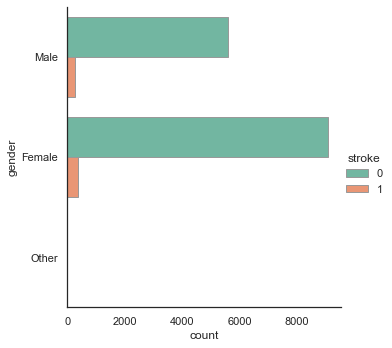

stroke vs gender(Count)


gender,Female,Male,Other
stroke,,,
0,9078,5593,1
1,368,264,0


stroke vs gender(%)


gender,Female,Male,Other
stroke,,,
0,96.104171,95.492573,100.000000
1,3.895829,4.507427,0.000000



Tests of proportions


For gender=Male the p-value of the proportion test with overall population is 0.2220721540548577

For gender=Female the p-value of the proportion test with overall population is 0.3641430988298644

For gender=Other the p-value of the proportion test with overall population is 0.835583881927237

There is no significant relationship between gender and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  3.4587986896949725

p-value:  0.1773909287515115

There is no significant relationship between gender and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between hypertension and stroke



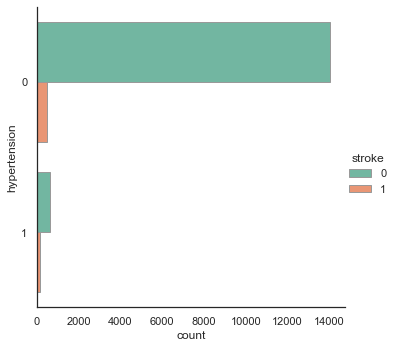

stroke vs hypertension(Count)


hypertension,0,1
stroke,,
0,14039,633
1,504,128


stroke vs hypertension(%)


hypertension,0,1
stroke,,
0,96.534415,83.180026
1,3.465585,16.819974



Tests of proportions


For hypertension=0 the p-value of the proportion test with overall population is 0.0027275272480266543

For hypertension=1 the p-value of the proportion test with overall population is 2.7760107550467402e-58

There exists a significant relationship between hypertension and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  322.3862718683532

p-value:  4.376485561971479e-72

There exists a significant relationship between hypertension and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between heart_disease and stroke



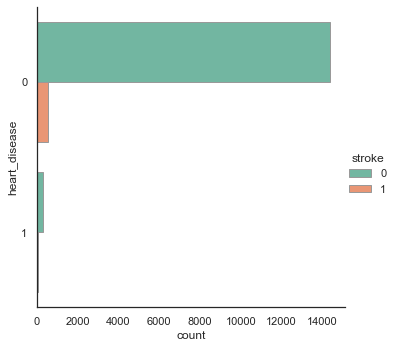

stroke vs heart_disease(Count)


heart_disease,0,1
stroke,,
0,14381,291
1,566,66


stroke vs heart_disease(%)


heart_disease,0,1
stroke,,
0,96.213287,81.512605
1,3.786713,18.487395



Tests of proportions


For heart_disease=0 the p-value of the proportion test with overall population is 0.1262481088556446

For heart_disease=1 the p-value of the proportion test with overall population is 1.2961255938100568e-38

There exists a significant relationship between heart_disease and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  186.62994390142546

p-value:  1.7297181563695063e-42

There exists a significant relationship between heart_disease and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between ever_married and stroke



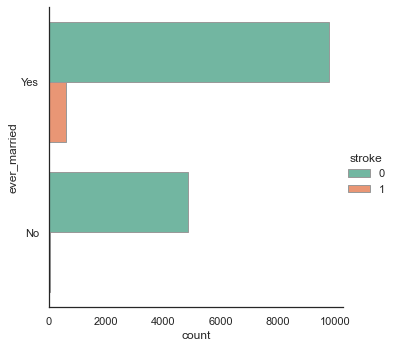

stroke vs ever_married(Count)


ever_married,No,Yes
stroke,,
0,4878,9794
1,41,591


stroke vs ever_married(%)


ever_married,No,Yes
stroke,,
0,99.166497,94.309100
1,0.833503,5.690900



Tests of proportions


For ever_married=Yes the p-value of the proportion test with overall population is 8.063036702065959e-09

For ever_married=No the p-value of the proportion test with overall population is 3.5554966874886877e-29

There exists a significant relationship between ever_married and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  197.6999165850637

p-value:  6.634004615091177e-45

There exists a significant relationship between ever_married and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between work_type and stroke



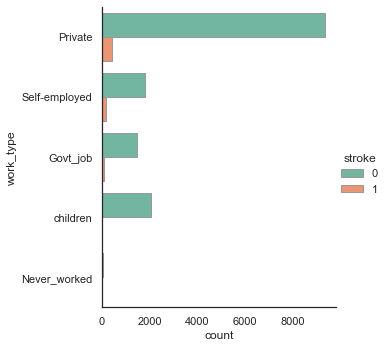

stroke vs work_type(Count)


work_type,Govt_job,Never_worked,Private,Self-employed,children
stroke,,,,,
0,1464,42,9348,1781,2037
1,69,0,404,158,1


stroke vs work_type(%)


work_type,Govt_job,Never_worked,Private,Self-employed,children
stroke,,,,,
0,95.499022,100.000000,95.857260,91.851470,99.950932
1,4.500978,0.000000,4.142740,8.148530,0.049068



Tests of proportions


For work_type=Private the p-value of the proportion test with overall population is 0.9594972259570994

For work_type=Self-employed the p-value of the proportion test with overall population is 1.5380955418318625e-15

For work_type=Govt_job the p-value of the proportion test with overall population is 0.48772204841537237

For work_type=children the p-value of the proportion test with overall population is 2.7625251062187054e-20

For work_type=Never_worked the p-value of the proportion test with overall population is 0.17863459322636988

There exists a significant relationship between work_type and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  167.16405963184633

p-value:  4.246819158364599e-35

There exists a significant relationship between work_type and stroke

__________________________________________________________________________________________
____________

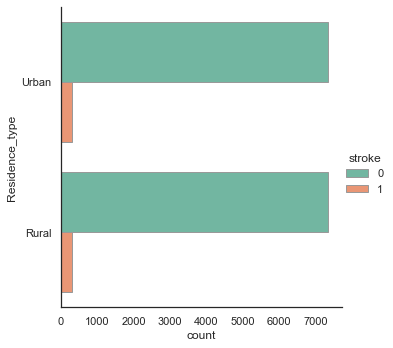

stroke vs Residence_type(Count)


Residence_type,Rural,Urban
stroke,,
0,7347,7325
1,317,315


stroke vs Residence_type(%)


Residence_type,Rural,Urban
stroke,,
0,95.863779,95.876963
1,4.136221,4.123037



Tests of proportions


For Residence_type=Urban the p-value of the proportion test with overall population is 0.9810963608577977

For Residence_type=Rural the p-value of the proportion test with overall population is 0.9811454401690077

There is no significant relationship between Residence_type and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  1.3033694318038267e-07

p-value:  0.9997119460614856

There is no significant relationship between Residence_type and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between smoking_status and stroke



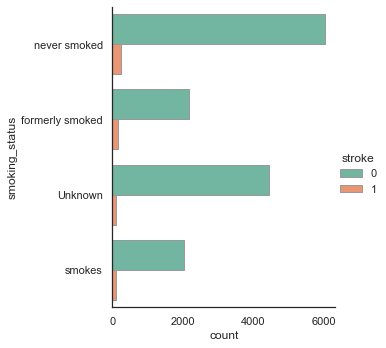

stroke vs smoking_status(Count)


smoking_status,Unknown,formerly smoked,never smoked,smokes
stroke,,,,
0,4435,2178,6024,2035
1,108,159,257,108


stroke vs smoking_status(%)


smoking_status,Unknown,formerly smoked,never smoked,smokes
stroke,,,,
0,97.622716,93.196406,95.908295,94.960336
1,2.377284,6.803594,4.091705,5.039664



Tests of proportions


For smoking_status=never smoked the p-value of the proportion test with overall population is 0.8986331157876666

For smoking_status=formerly smoked the p-value of the proportion test with overall population is 5.9624537009795545e-09

For smoking_status=Unknown the p-value of the proportion test with overall population is 4.391565192849969e-08

For smoking_status=smokes the p-value of the proportion test with overall population is 0.05025681388177272

There exists a significant relationship between smoking_status and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  81.94741959290633

p-value:  1.1728907020266432e-17

There exists a significant relationship between smoking_status and stroke

__________________________________________________________________________________________
_________________________________________________________________________________________

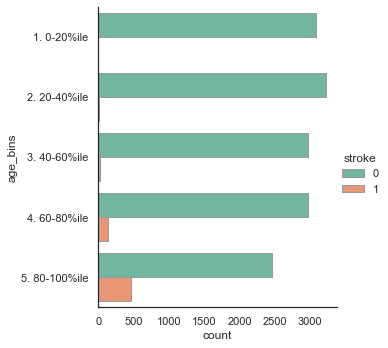

stroke vs age_bins(Count)


age_bins,1. 0-20%ile,2. 20-40%ile,3. 40-60%ile,4. 60-80%ile,5. 80-100%ile
stroke,,,,,
0,3076,3217,2964,2961,2454
1,1,10,24,140,457


stroke vs age_bins(%)


age_bins,1. 0-20%ile,2. 20-40%ile,3. 40-60%ile,4. 60-80%ile,5. 80-100%ile
stroke,,,,,
0,99.967501,99.690115,99.196787,95.485327,84.300928
1,0.032499,0.309885,0.803213,4.514673,15.699072



Tests of proportions


For age_bins=2. 20-40%ile the p-value of the proportion test with overall population is 4.156519169970019e-27

For age_bins=3. 40-60%ile the p-value of the proportion test with overall population is 3.741069093524809e-19

For age_bins=4. 60-80%ile the p-value of the proportion test with overall population is 0.32940069953643425

For age_bins=5. 80-100%ile the p-value of the proportion test with overall population is 1.1308369994599197e-128

For age_bins=1. 0-20%ile the p-value of the proportion test with overall population is 5.7337347746343326e-30

There exists a significant relationship between age_bins and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  1318.2305534628285

p-value:  3.711010310283559e-284

There exists a significant relationship between age_bins and stroke

__________________________________________________________________________________________


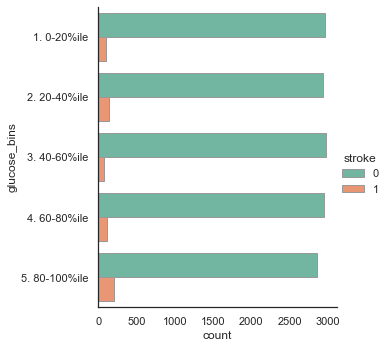

stroke vs glucose_bins(Count)


glucose_bins,1. 0-20%ile,2. 20-40%ile,3. 40-60%ile,4. 60-80%ile,5. 80-100%ile
stroke,,,,,
0,2966,2932,2970,2947,2857
1,97,136,81,114,204


stroke vs glucose_bins(%)


glucose_bins,1. 0-20%ile,2. 20-40%ile,3. 40-60%ile,4. 60-80%ile,5. 80-100%ile
stroke,,,,,
0,96.833170,95.567145,97.345133,96.275727,93.335511
1,3.166830,4.432855,2.654867,3.724273,6.664489



Tests of proportions


For glucose_bins=2. 20-40%ile the p-value of the proportion test with overall population is 0.4437336159865394

For glucose_bins=5. 80-100%ile the p-value of the proportion test with overall population is 8.155961677068542e-10

For glucose_bins=1. 0-20%ile the p-value of the proportion test with overall population is 0.012723354676796613

For glucose_bins=3. 40-60%ile the p-value of the proportion test with overall population is 0.00011834771383868093

For glucose_bins=4. 60-80%ile the p-value of the proportion test with overall population is 0.2996931900316736

There exists a significant relationship between glucose_bins and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  75.59441560065397

p-value:  1.49170069444104e-15

There exists a significant relationship between glucose_bins and stroke

_________________________________________________________________________

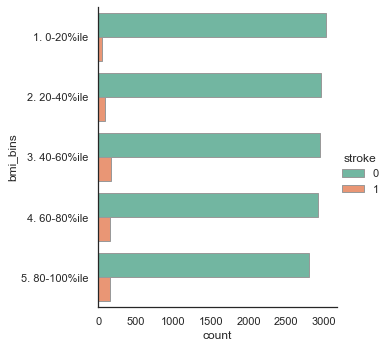

stroke vs bmi_bins(Count)


bmi_bins,1. 0-20%ile,2. 20-40%ile,3. 40-60%ile,4. 60-80%ile,5. 80-100%ile
stroke,,,,,
0,3027,2960,2951,2922,2812
1,47,89,174,161,161


stroke vs bmi_bins(%)


bmi_bins,1. 0-20%ile,2. 20-40%ile,3. 40-60%ile,4. 60-80%ile,5. 80-100%ile
stroke,,,,,
0,98.471047,97.081010,94.432000,94.777814,94.584595
1,1.528953,2.918990,5.568000,5.222186,5.415405



Tests of proportions


For bmi_bins=4. 60-80%ile the p-value of the proportion test with overall population is 0.006442455634917321

For bmi_bins=2. 20-40%ile the p-value of the proportion test with overall population is 0.0016767973744358155

For bmi_bins=5. 80-100%ile the p-value of the proportion test with overall population is 0.0016389250123843972

For bmi_bins=3. 40-60%ile the p-value of the proportion test with overall population is 0.00033975722545066583

For bmi_bins=1. 0-20%ile the p-value of the proportion test with overall population is 3.045414527254265e-12

There exists a significant relationship between bmi_bins and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  101.84209531458316

p-value:  3.986698903862355e-21

There exists a significant relationship between bmi_bins and stroke

__________________________________________________________________________________________
__

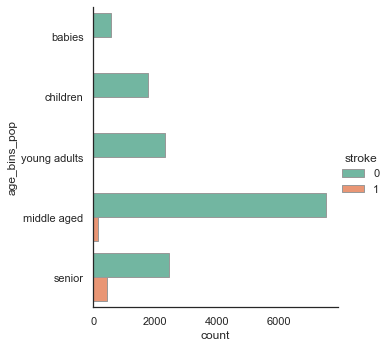

stroke vs age_bins_pop(Count)


age_bins_pop,babies,children,young adults,middle aged,senior
stroke,,,,,
0,585,1788,2330,7515,2454
1,0,1,1,173,457


stroke vs age_bins_pop(%)


age_bins_pop,babies,children,young adults,middle aged,senior
stroke,,,,,
0,100.000000,99.944103,99.957100,97.749740,84.300928
1,0.000000,0.055897,0.042900,2.250260,15.699072



Tests of proportions


For age_bins_pop=young adults the p-value of the proportion test with overall population is 5.049390283032361e-23

For age_bins_pop=middle aged the p-value of the proportion test with overall population is 2.589879302697772e-13

For age_bins_pop=senior the p-value of the proportion test with overall population is 1.1308369994599197e-128

For age_bins_pop=children the p-value of the proportion test with overall population is 5.943369762659963e-18

For age_bins_pop=babies the p-value of the proportion test with overall population is 5.278947951096013e-07

There exists a significant relationship between age_bins_pop and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  1251.2787644413092

p-value:  1.2169880831173691e-269

There exists a significant relationship between age_bins_pop and stroke

______________________________________________________________________________

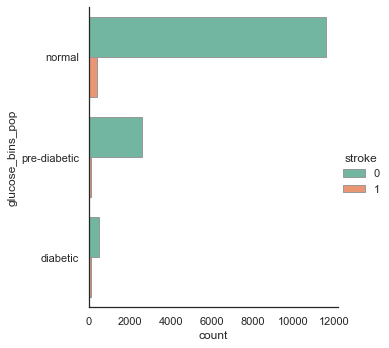

stroke vs glucose_bins_pop(Count)


glucose_bins_pop,normal,pre-diabetic,diabetic
stroke,,,
0,11603,2579,490
1,426,94,112


stroke vs glucose_bins_pop(%)


glucose_bins_pop,normal,pre-diabetic,diabetic
stroke,,,
0,96.458558,96.483352,81.395349
1,3.541442,3.516648,18.604651



Tests of proportions


For glucose_bins_pop=normal the p-value of the proportion test with overall population is 0.012332765467620741

For glucose_bins_pop=pre-diabetic the p-value of the proportion test with overall population is 0.137441476922687

For glucose_bins_pop=diabetic the p-value of the proportion test with overall population is 3.7826344752927166e-61

There exists a significant relationship between glucose_bins_pop and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  331.6430115185466

p-value:  9.652394596586073e-73

There exists a significant relationship between glucose_bins_pop and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________


Exploring relationship between bmi_bins_pop and stroke



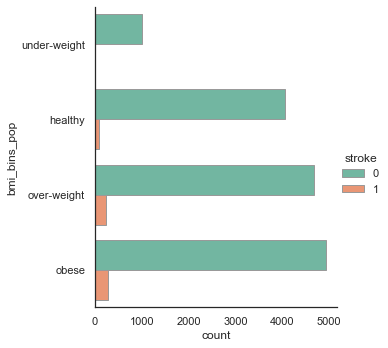

stroke vs bmi_bins_pop(Count)


bmi_bins_pop,under-weight,healthy,over-weight,obese
stroke,,,,
0,1012,4052,4680,4928
1,2,97,248,285


stroke vs bmi_bins_pop(%)


bmi_bins_pop,under-weight,healthy,over-weight,obese
stroke,,,,
0,99.802761,97.662087,94.967532,94.532899
1,0.197239,2.337913,5.032468,5.467101



Tests of proportions


For bmi_bins_pop=obese the p-value of the proportion test with overall population is 5.432521395408782e-05

For bmi_bins_pop=healthy the p-value of the proportion test with overall population is 7.05191389514482e-08

For bmi_bins_pop=over-weight the p-value of the proportion test with overall population is 0.006882997975605078

For bmi_bins_pop=under-weight the p-value of the proportion test with overall population is 3.487941982405017e-10

There exists a significant relationship between bmi_bins_pop and stroke

__________________________________________________________________________________________

Chi-square Test

Chi-square test statistic:  106.9474952155278

p-value:  4.979402102911219e-23

There exists a significant relationship between bmi_bins_pop and stroke

__________________________________________________________________________________________
__________________________________________________________________________________________



In [22]:
#[catp('stroke',item,train) for item in cat if 'stroke' not in item]
for item in cat:
    if item=='stroke':
        continue
    catp('stroke',item,train)

In [23]:
def remove_outlier(x):
    med=x.median()
    upq=np.percentile(x,75)
    lwq=np.percentile(x,25)
    iqr=upq-lwq
    x_n=np.where(x>med+1.5*iqr,med+1.5*iqr,np.where(x<med-1.5*iqr,med-1.5*iqr,x))
    val=[med,iqr] #returns the median and iqr values so that they can be applied on the test data
    return x_n,val

In [24]:
train['age_iqr'], age_limits=remove_outlier(train['age'])
train['bmi_iqr'], bmi_limits=remove_outlier(train['bmi'])
train['glucose_iqr'], glucose_limits=remove_outlier(train['avg_glucose_level'])

In [25]:
train['age_log']=np.log(train['age'])
train['bmi_log']=np.log(train['bmi'])
train['glucose_log']=np.log(train['avg_glucose_level'])
train['age_iqr_log']=np.log(train['age_iqr'])
train['bmi_iqr_log']=np.log(train['bmi_iqr'])
train['glucose_iqr_log']=np.log(train['glucose_iqr'])



Distribution of age_iqr



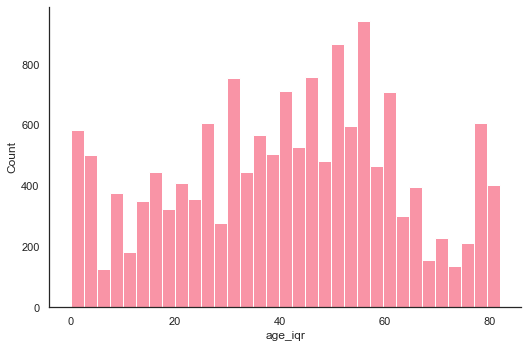


The skew of age_iqr is -0.10 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of bmi_iqr



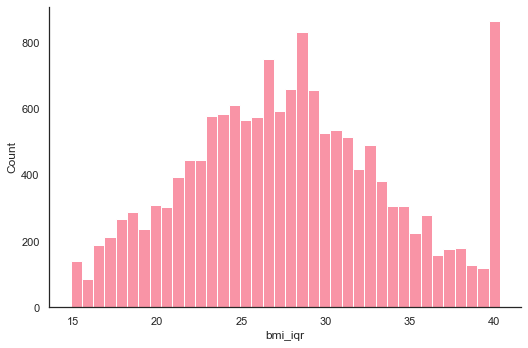


The skew of bmi_iqr is 0.19 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of glucose_iqr



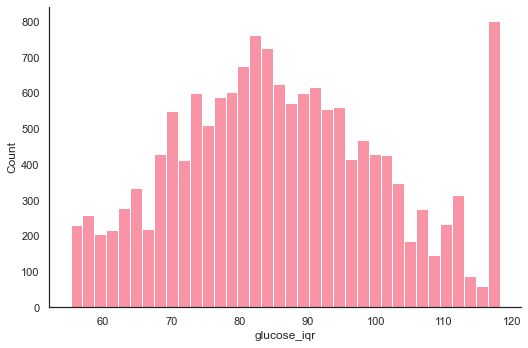


The skew of glucose_iqr is 0.22 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of age_log



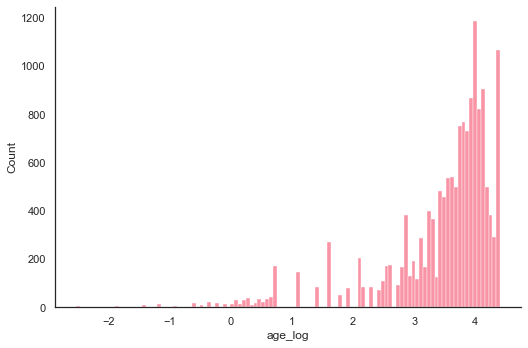


The skew of age_log is -2.10 which indicates that it is skewed towards the head

__________________________________________________________________________________________



Distribution of bmi_log



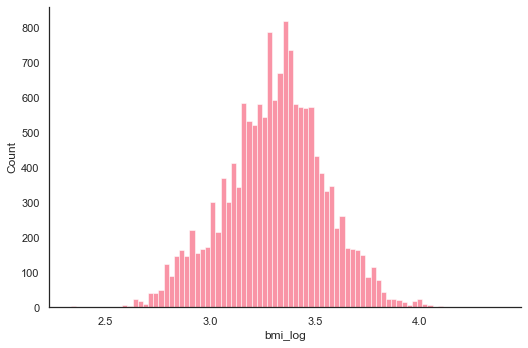


The skew of bmi_log is -0.10 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of glucose_log



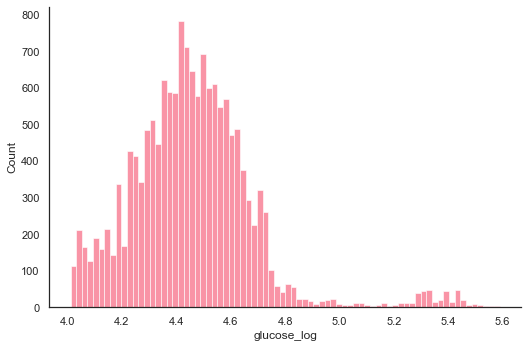


The skew of glucose_log is 1.31 which indicates that it is skewed towards the tail

__________________________________________________________________________________________



Distribution of age_iqr_log



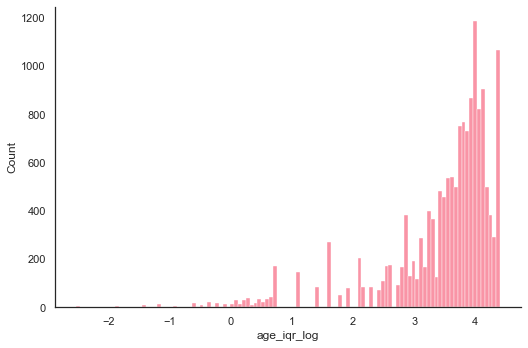


The skew of age_iqr_log is -2.10 which indicates that it is skewed towards the head

__________________________________________________________________________________________



Distribution of bmi_iqr_log



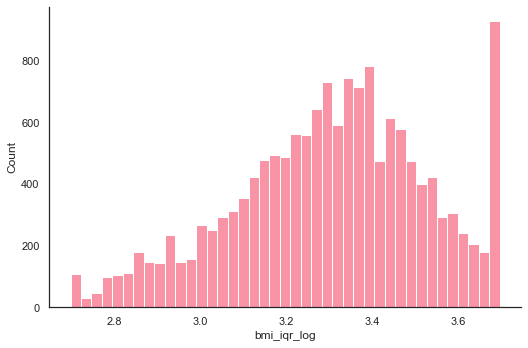


The skew of bmi_iqr_log is -0.32 which indicates that it is fairly symmetric

__________________________________________________________________________________________



Distribution of glucose_iqr_log



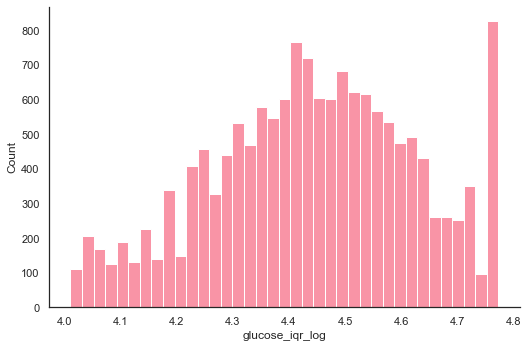


The skew of glucose_iqr_log is -0.16 which indicates that it is fairly symmetric

__________________________________________________________________________________________



In [26]:
for i in ['age_iqr', 'bmi_iqr', 'glucose_iqr', 'age_log', 'bmi_log','glucose_log','age_iqr_log', 'bmi_iqr_log', 'glucose_iqr_log']:
    skew_chart(train,i,train[i])